In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from glob import glob
import re
from pathlib import Path

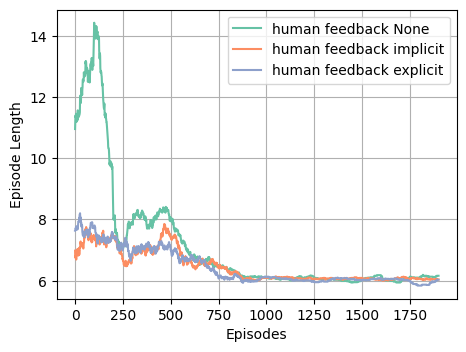

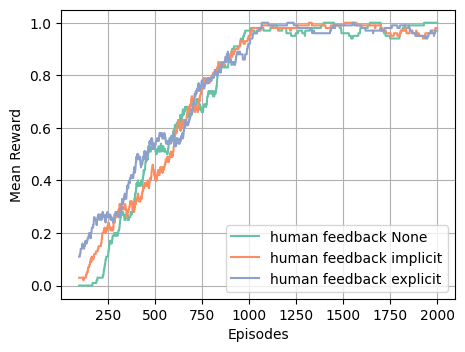

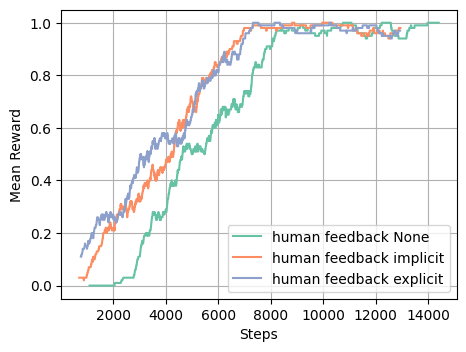

In [3]:
import json
from io import StringIO


def folders_and_params(filters={}):
    folders = []
    folder_params = []
    log_dir = Path("logs")
    for folder in log_dir.glob("*"):
        with open(folder / "params.json") as fd:
            params = json.load(fd)

            should_add = True
            for k, v in filters.items():
                if params[k] != v:
                    should_add = False

            if should_add:
                folders.append(folder)
                folder_params.append(params)

    ret = list(zip(folders, folder_params))
    ret.sort(key=lambda x: x[0])

    return ret


def read_monitor_data(monitor_folder, rolling_length=100):
    # monitor_folder = f / "monitor"
    monitor_files = list(monitor_folder.glob("*.csv"))
    merged_monitor_data = ""
    for monitor_file in monitor_files:
        with open(monitor_file, "r") as fd:
            cmt = fd.readline()
            hdr = fd.readline()
            if merged_monitor_data == "":
                merged_monitor_data += cmt
                merged_monitor_data += hdr
            merged_monitor_data += fd.read()

    df = pd.read_csv(StringIO(merged_monitor_data), skiprows=1)
    df = df.sort_values("t")

    df["steps"] = df["l"].cumsum()

    mean_rewards = df["r"].rolling(rolling_length).mean().to_list()
    steps = df["steps"].tolist()

    return mean_rewards, steps


figsize = np.array([6.4, 4.8]) / 1.4


def plot_learning_curve(folders_and_params, labels, max_length=-1, rolling_length=100):
    fig1 = plt.figure(1, figsize=figsize)
    fig2 = plt.figure(2, figsize=figsize)
    fig3 = plt.figure(3, figsize=figsize)
    colors = sns.color_palette("Set2", len(folders_and_params))
    for (f, p), l, c in zip(folders_and_params, labels, colors):
        mean_rewards, steps = read_monitor_data(f, rolling_length=rolling_length)

        # if len(steps) > 16:
        #     steps = steps[2::4]
        #     mean_rewards = mean_rewards[2::4]

        if max_length < 0:
            max_length = len(steps)
        plt.figure(fig1)
        plt.plot(
            mean_rewards[:max_length],
            label=l,
            color=c,
        )

        plt.figure(fig2)
        plt.plot(
            steps[:max_length],
            mean_rewards[:max_length],
            label=l,
            color=c,
        )

        plt.figure(fig3)

        episode_length = np.diff(steps)
        episode_length = np.convolve(episode_length, np.ones(rolling_length) / rolling_length, mode="valid")
        plt.plot(
            episode_length[:max_length],
            label=l,
            color=c,
        )

    for fig in [fig1, fig2, fig3]:
        plt.figure(fig)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.ylabel("Mean Reward")

    plt.figure(fig3)
    plt.ylabel("Episode Length")
    plt.xlabel("Episodes")

    plt.figure(fig1)
    plt.xlabel("Episodes")
    plt.figure(fig2)
    plt.xlabel("Steps")


fnp = [(f, p) for f, p in folders_and_params({}) if "2024-05-03_14" in str(f)][-3:]
# fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = [f"human feedback {p['human_feedback']}" for f, p in fnp]
plot_learning_curve(fnp, labels, max_length=2000, rolling_length=100)

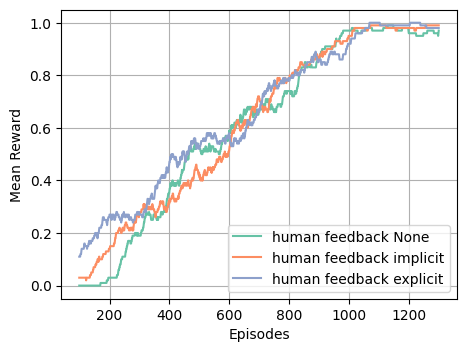

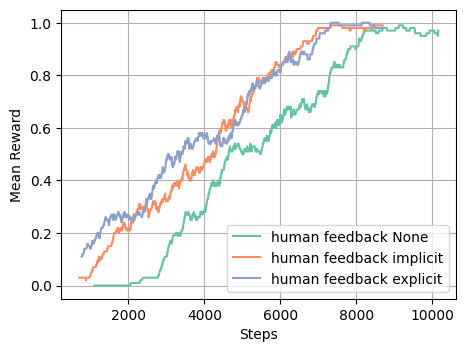

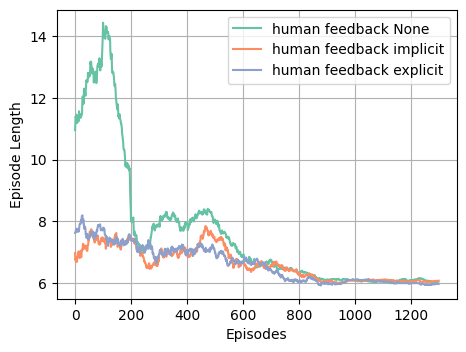

In [4]:
fnp = [(f, p) for f, p in folders_and_params({}) if "2024-05-03_14" in str(f)][-3:]
# fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = [f"human feedback {p['human_feedback']}" for f, p in fnp]
plot_learning_curve(fnp, labels, max_length=1300, rolling_length=100)
plt.figure(1)
plt.savefig("report/figures/learning_curve_episodes.png", bbox_inches="tight")
plt.figure(2)
plt.savefig("report/figures/learning_curve_steps.png", bbox_inches="tight")
plt.figure(3)
plt.savefig("report/figures/episode_length.png", bbox_inches="tight")


In [5]:
def plot_average_learning_curve(folders_and_params, labels):
    plt.figure(figsize=figsize)
    params = [p for f, p in folders_and_params]
    for i in range(len(params)):
        params[i]["seed"] = 0

    params_set = []
    for p in params:
        if p not in params_set:
            params_set.append(p)

    colors = sns.color_palette("Set2", len(params_set))
    # colors = sns.color_palette()

    for i, p_group in enumerate(params_set):
        group_steps = []
        group_mean_rewards = []

        good_p = {}
        for f, p in folders_and_params:
            p["seed"] = 0
            if p_group == p:
                good_p = p
                mean_rewards, steps = read_monitor_data(f)
                mean_rewards = mean_rewards[::10]
                steps = steps[::10]

                group_steps.append(steps)
                group_mean_rewards.append(mean_rewards)

                plt.plot(
                    steps, mean_rewards,
                    color = colors[i], alpha=0.4
                )

        average_mean_rewards = []
        for step in group_steps[0]:
            average_mean_rewards.append(
                np.mean([g[np.argmin([np.abs(step - s) for s in group_steps[i]])] for i, g in enumerate(group_mean_rewards)])
            )

        plt.plot(
            group_steps[0], average_mean_rewards, label=labels(f, good_p),
            color = colors[i]
        )

    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")

fnp = [
    (f, p)
    for f, p in folders_and_params(
        {
            "num_training_steps": 500000,
            "learning_rate": 0.0003,
            "gamma": 0.9,
            "exploration_fraction": 0.9,
        }
    )
]
fnp.sort(key=lambda x: x[1]["learningAlg"])
labels = lambda f, p: f"{p['learningAlg']}"

print(labels)
plot_average_learning_curve(fnp, labels)

plt.savefig("../report/figures/compare_alg.png")

KeyError: 'num_training_steps'

0 {'prob': 1}


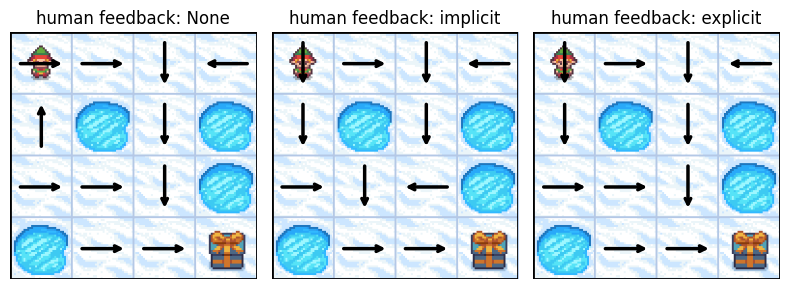

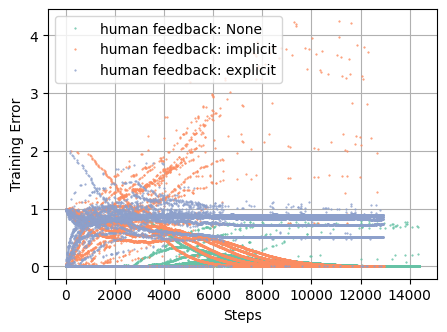

In [9]:
import pickle
import gymnasium as gym
import matplotlib.patches as patches

fnp = [(f, p) for f, p in folders_and_params({}) if "2024-05-03_14" in str(f)][-3:]
# fnp.sort(key=lambda x: x[1]["learning_rate"])
labels = [f"human feedback: {p['human_feedback']}" for f, p in fnp]

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

# reset the environment to get the first observation
done = False
observation, info = env.reset()

print(observation, info)

img = env.render()
# plt.imshow(img)

# # sample a random action from all valid actions
# # action = env.action_space.sample()
# action=2


# # execute the action in our environment and receive infos from the environment
# observation, reward, terminated, truncated, info = env.step(action)

# plt.figure()
# img = env.render()
# plt.imshow(img)

fig, axes = plt.subplots(1, len(fnp), figsize=np.array([1, len(fnp)]) * 8)
fig2 = plt.figure(figsize=figsize)
a = 0
colors = sns.color_palette("Set2", len(labels))

for (f, p), l, c in zip(fnp,labels, colors):
    with open(f / "q_values.pkl", "rb") as fd:
        q_values = pickle.load(fd)
    with open(f / "training_error.pkl", "rb") as fd:
        training_error = pickle.load(fd)


    # training_error = np.convolve(training_error, np.ones(100)/100, mode='valid')

    axes[a].imshow(img)

    final_q_values = np.zeros([4,4,4])
    for key, val in q_values.items():
        col = key % 4
        row = key // 4

        final_q_values[row, col] = val

    optimal_policy = np.argmax(final_q_values, axis=2)

    for i in range(4):
        for j in range(4):
            if  optimal_policy[j, i] == 0:
                dx = -0.5
                dy = 0
            elif optimal_policy[j, i] == 1:
                dx = 0
                dy = 0.5
            elif optimal_policy[j, i] == 2:
                dx = 0.5
                dy = 0
            elif optimal_policy[j, i] == 3:
                dx = 0
                dy = -0.5
            # ax[0].arrow(i, j, dx, dy)
            scale_factor = img.shape[0] / 4
            dx = dx * scale_factor / 1.3
            dy = dy * scale_factor / 1.3
            x = (i+.5) * scale_factor
            y = (j+.5) * scale_factor

            if np.all(final_q_values[j, i] == 0):
                continue
            axes[a].annotate("", xy=(x+dx, y+dy), xytext=(x-dx, y-dy),
                arrowprops=dict(arrowstyle="->", lw=2.5))

    # draw a rectangle around the subplot
    x_lims = axes[a].get_xlim()
    y_lims = axes[a].get_ylim()
    rect  = patches.Rectangle(
        (x_lims[0], y_lims[0]), x_lims[1] - x_lims[0], y_lims[1] - y_lims[0],
        linewidth=2, edgecolor='black', facecolor='none'
    )
    axes[a].add_patch(rect)

    axes[a].axis('off')

    axes[a].grid()
    axes[a].set_title(l)
    a += 1

    plt.figure(fig2)
    plt.plot(training_error, ".", ms=1, label=l, color=c)

plt.figure(fig)
plt.tight_layout()
plt.savefig("report/figures/optimal_policy.png", bbox_inches="tight")

plt.figure(fig2)
plt.grid()
plt.legend()
plt.ylabel("Training Error")
plt.xlabel("Steps")
plt.tight_layout()
plt.savefig("report/figures/training_error.png", bbox_inches="tight")

In [ ]:
training_error